In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from custom_functions import get_sales_change_rates_percent, get_abs_err_confidence_interval, show_data


# Daten gleich, Konfidenzintervalle anders. Wie kann das sein?

Hi! Schön, dass Du wieder dabei bist. Mir ist aufgefallen, dass viele Python-Packages (und Menschen) Konfidenzintervalle immer auf die gleiche Art und Weise berechnen und dabei implizite Prämissen annehmen, die nicht zwangsläufig erfüllt sein müssen.

Diese Prämissen sind z.B.
- Wir nehmen ein 95% Konfidenzintervall an.
- Wir nehmen ein zweiseitiges Konfidenzintervall an.
- Wir ziehen "mit Zurücklegen".
- Wir nehmen eine "unendliche" Grundgesamtheit an.
- Wir "kennen" die Grundgesamtheit nicht.
- Wir nehmen eine Normalverteilung an.

"Schuld" daran ist häufig die akademische Sozialisierung. Ihr kennt es z.B. aus vielen Vorlesungen oder Büchern: "In der Regel sind die Parameter der »Grundgesamtheit« unbekannt [...]" (http://eswf.uni-koeln.de/glossar/node145.html) Aber ist das im Businesskontext tatsächlich immer so?

Um auf eine einfache Weise in die Konzepte einzusteigen, starten zunächst immer mit dem Beispiel des "Ein-Stichproben-Falls". Disclaimer (wie immer): Ich vermische hier aus didaktischen Gründen einiges. Z.B. Erwartungswert, Mittelwert etc. Es geht jedoch hier nur darum, die o.g. Prämissen zu variieren, um zu verstehen, welchen Einfluss sie haben. Ich gehe dabei von statistischem Vorwissen aus, da sich der Beitrag an Data Scientists wendet.

# Zuerst mal ein paar Grundbegriffe
## Inferenzstatistik

Die Begriffe "Signifikanz" oder auch "Konfidenzintervall" stehen auf dem Fundament der Inferenzstatistik. In der Inferenzstatistik geht es darum, von den Eigenschaften einer __Zufallsstichprobe__ auf die Eigenschaften einer __Grundgesamtheit__ zu schließen. 

Beispiel: Ich befrage 1.000 zufällig ausgewählte Deutsche Haushalte zu ihrem Wahlverhalten, um eine Einschätzung zu bekommen, wie wohl ganz Deutschland wählen würden. Dieser Schluss vom Teil auf das Gesamte ist natürlich mit Unsicherheit verbunden. Wenn ich zu 100% sicher sein möchte, muss ich leider alle fragen, und nicht nur einen Teil. Wenn ich aber einen Teil befrage, kann ich zumindest die Unsicherheit quantifizieren. Das funktioniert jedoch nur, wenn ich die Befragten zufällig auswähle! Klingt paradox, oder? Nach inhaltlichen Kriterien könnte ich sicher bewusst Personen auswählen, die besser geeignet wären, um von Teil aufs Ganze zu schließen. Nur dann verliere ich leider den "magic trick" - nämlich genau sagen zu können, WIE sicher ich denn bin die Eigenschaften auch in der GG wiederzufinden. #isso. Grundsätzlich werde ich immer mehr Vertrauen in die Aussagen aus meiner Stichprobe haben, wenn die Stichprobe größer ist und wenn sich die Eigenschaften in der Stichprobe nicht stark unterscheiden.

Eigenschaften der Grundgesamtheit (häufig GG abgekürzt) können z.B. sein:
- Der Mittelwert: µ ("mü")
- Die Streuung: σ ("sigma")
- Die Verteilungsart der Daten in der GG

FAZIT: Inferenzstatistik (und somit "Signifikanz" und "Konfidenzintervall") machen also keinen Sinn, wenn...
- ... ich keine Grundgesamtheit habe oder nicht auf eine Grundgesamtheit schließen möchte.
- ... meine Stichprobe nicht zufällig ausgewählt ist.

## Signifikanz
Beispiel: 

Ich teste ein neues Konzept für Supermärkte. 
- Dafür wähle ich zufällig 30 Supermärkte aus. 
- Ich beobachte, dass Märkte mit dem neuen Konzept durchschnittlich 4% mehr Umsatz machen als im Jahr zuvor. 
- Alle 120 Supermärkte in Summe erwirtschaften im selben Zeitraum 2% mehr Umsatz. 
- Das heißt, Test-Märkte haben eine um zwei Prozentpunkte verbesserte Umsatzentwicklung. 

Und nun kommt wie immer eine Frage: "Ist das signifikant?".

Was bedeutet "signifikant" nicht?
- Besonders bedeutsam
- Wichtig

Wenn wir von der __Bedeutsamkeit__ sprechen, meinen wir die 2 Prozentpunkte. Dies nennen wir in der Statistik "Effektstärke". Diese hat in der Businesswelt eine viel größere Bedeutung, da sich im Business eher Fragen stellen wie: "Reichen die 2% mehr Umsatz, um den Business Case positiv zu rechnen?". In der Wissenschaft formulieren wir eher Vermutungen wie: "Das Konzept hat einen positiven Einfluss." und prüfen diese.

Etwas ungangssprachlich ausgedrückt beantwortet Signifikanz eher folgenden Frage: 
> "Kann ich ausschließen, dass der Unterschied von 2 Prozentpunkten eigentlich nur daher rührt, dass ich __diese 30 Märkte__ zufällig ausgewählt habe (und nicht andere)." 

Oder anders: 
> "Wenn ich das Konzept in allen 120 Märkte (GG) einführen würde, sähe ich diesen Effekt auch dort?" 

Und weil wir nie etwas zu 100% ausschließen können (s.o.), müssen wir auch sagen, wie sicher wir uns sein möchten. Überlicherweise verwendet man in den Sozialwissenschaften und im Business einen Wert von 95%, während man in der Physik häufig sehr viel höhere Werte verwendet. Diese Werte werden auch Signifikanzniveaus genannt. Ich sage also: "Ich kann mit 95%-iger Sicherheit ausschließen, dass sich der Mittelwertunterschied nur durch meine Zufallsauswahl ergibt." Man darf also genau genommen nie sagen, dass ein Effekt "signifikant" ist, ohne auch das Signifikanzniveau zu nennen? Wenn ich nur 50% sicher sein möchte, dann ist nämlich fast jeder Effekt "signifikant" ;)

Lass uns mal mit etwas Intuition überlegen, was passieren muss, damit ich dem Mittelwertunterschied mehr vertrauen kann, wenn wir alles andere gleich halten:
- Ich vertraue mehr, wenn ich __mehr Märkte__ teste. Wenn ich im Extremfall alle 120 Märkte mit dem Konzept beglücke, bin ich zu 100% sicher. Es wären ja dann alle, auf die ich schließen möchte. Wenn ich nur einen Markt teste, vertraue ich weniger, da der Einfluss meiner zufälligen Auswahl riesig wird.
- Ich vertraue mehr, wenn die Stichprobe und die Grundgesamtheit __wenig streuen__. Wenn sich der Mittelwert der Stichprobe aus einer kleinen Bandbreite an Werten ergibt fühle ich mich sicherer - z.B. 3,5%-4,5%. Wenn sich der Mittelwert aus einer großen Bandbreite ergibt (z.B. -2% bis +10%) würde ich mir schon mehr sorgen machen.
- Ich vertraue mehr, wenn der __Unterschied__ (bei gleicher Streuung und gleicher Anzahl der Märkte) größer ist. Einem Unterschied von +10 Prozentpunkten vertraue ich mehr als einem Unterschied von 0,1 Prozentpunkten.

Dabei ergibt sich die __Prüfgröße__, der mir sagt, wie sicher ich sein kann, aus einer der folgenden Formeln. Dafür muss ich wissen, ob die __Steuung der Grundgesamtheit__ bekannt ist. Wenn das der Fall ist, sollte ich diese verwenden, und nicht die Streuung der Stichprobe. Als zweites muss ich wissen, ob ich mit oder ohne __"Zurücklegen"__ aus Grundgesamtheit gezogen habe. Anders ausgedrückt: Könnte ein Fall auch mehrfach aus der GG gezogen werden? 

Wenn die Prüfgröße größer ist, als der __kritische Wert__ für ein Signifikanzniveau, dann nennen wir den Unterschied "signifikant zum Signifikanzniveau X%". Den kritischen Wert kann man z.B. aus Tabellen ablesen, die sich häufig am Ende vieler Statistikbücher befinden. :)

![induktive1](fallunterscheidung.png "Peter von der Lippe (r.i.p.): Induktive Statistik, Abruf unter http://www.von-der-lippe.org/dokumente/INDFOR.pdf")

Aus dem oben genannten Entscheidungsbaum meines früheren Statistikprofessors Peter von der Lippe (r.i.p.) wird bereits schon jetzt deutlich, dass ich mit einem und demselben Datensatz __verschiede Prüfgrößen__ erhalten kann, wenn ich zusätzliche Informationen zur Grundgesamtheit oder zum Auswahlverfahren hinzuziehe.

## Konfidenzintervall
Nun gibt es Formeln, die mir sagen, ob ein Effekt signifikant ist, wenn die Informationen zur Streuung, Effektstärke, Stichproben- sowie GG-Größe und Signifikanzniveau zur Verfügung stelle (s.o.). Aber was, wenn ich nun wissen möchte, bei welcher Effektgröße ein Effekt signikant wird? Es wäre ja nervig, alle möglichen Effektstärken durchzuprobieren, um jeweils erfahren zu müssen ob sie signifikant ist. Und hier kommt das Konfidenzintervall (KI) ins Spiel!

Ein Konfidenzintervall besteht aus zwei Werten: einer unteren Grenze und einer oberen Grenze. Im Falle unseres Tests könnte man z.B. sagen:
- Mit 95% Wahrscheinlichkeit liegt die zu erwartende Umsatzsteigerung bei 120 Märkten zwischen 3% und 5%. Dies sind die untere und die obere Grenze.
- Da wir die Alternative "nichts tun" mit 2% bewerten, ist der Unterschied "signifikant" bei 95% Sicherheit.

Das KI wird dabei immer größer, je sicherer ich mir sein möchte. Wenn ich Effekte gut isolieren möchte, sind jedoch generell kleinere KI wünschenswert. Dies erreiche ich z.B. durch die richtige Wahl der Stichprobengröße.

Das Konfidenzintervall ergibt sich dabei wie folgt:

Mittelwert (hier: 4%) ± absoluter Fehler (hier: 1%) = [3%; 5%]

Wie oben beschrieben wird der absolute Fehler kleiner, wenn...
- ... die __Stichprobengröße__ einen größeren Teil der GG umfasst.
- ... die __Streuung__ kleiner wird.
- ... ich ein höheres __Signifikanzniveau__ zulasse. (Dann werden Effekte wahrscheinlicher "signifikant", jedoch ist diese signifikanz dann leider weniger "wert".)

Das liegt mathematisch daran, dass der abslute Fehler wie folgt ergibt:

$$Absoluter Fehler = Unsicherheit \dfrac{Streuung}{Fallzahl}$$

oder auch genauer:

$$Absoluter Fehler=Prüfgröße\dfrac{Standardabweichung}{\sqrt{Fallzahl}}$$

oder auch noch genauer:

$$e=z_\alpha\dfrac{\sigma}{\sqrt{n}}$$

# Beispiel
## Setting
Wir wählen 30 von 120 Supermärkten zufällig aus und beobachten deren Umsatzentwicklung. Nun ist die Frage, in welchem Intervall sich mit 95% Wahrscheinlichkeit die Umsatzentwicklung aller 120 Märkte in Summe befindet.

Dazu habe ich ein paar Funktionen selbstgeschrieben und oben importiert, um es hier didaktisch einfacher zu machen.

Zunächst besorgen wir uns die Daten und zeigen sie an:

n=30, mean=0.11901780297332658, std=0.18607539192172678


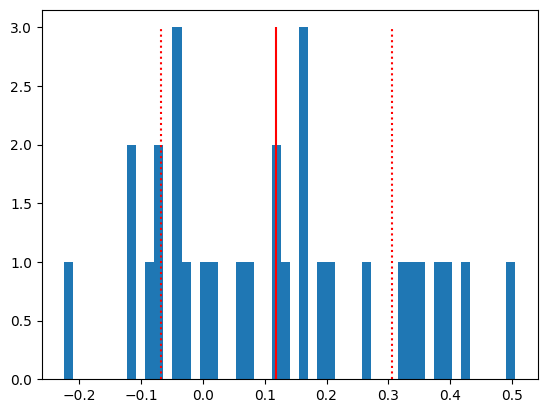

In [4]:
data = get_sales_change_rates_percent(n=30)
show_data(data)
plt.show()


Die 30 Märkte zeigen eine durchschnittliche Umsatzentwicklung von -1,8% und einer Streuung von 18,5 Prozentpunkten. Nun berechnen wir den absoluten Fehler, um zu sehen wie breit das KI ist. Wir verwenden hier die "Standardeinstellungen" die von vielen Softwarepackages verwendet werden.

## Standard Konfidenzintervall
Ganz vanilla: Ein Konfidenzintervall, wie es standardmäßig berechnet wird.

Der absolute Fehler beträgt ± 0.067
n=30, mean=0.11901780297332658, std=0.18607539192172678


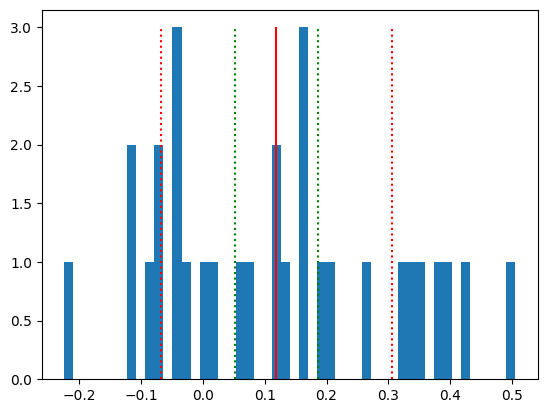

In [7]:
abs_fehler = get_abs_err_confidence_interval(obs=data)
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results = {"Standard": abs_fehler}
show_data(data, e=abs_fehler)

## Intervall mit Sicherheit 90%
Jetzt könnte es ja auch sein, dass dem Management auch eine 90%-ige Sicherheit reicht. Womöglich gibt es ja schon positive qualitative Rückmeldungen aus der Vertriebsorganisation und quantitative Ergebnisse der Marktforschung, die wir nicht so einfach in unsere Analyse einbinden können. Schauen wir mal, was dann passiert.

Der absolute Fehler beträgt ± 0.056
n=30, mean=0.11901780297332658, std=0.18607539192172678


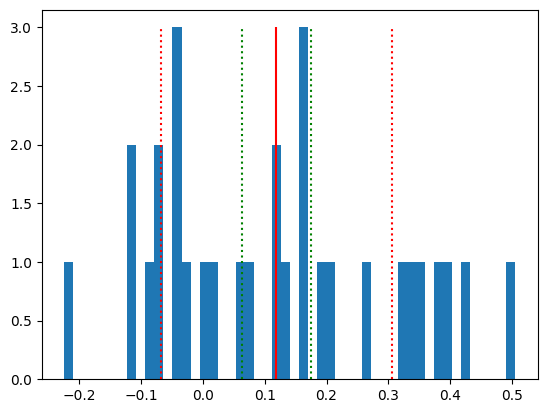

In [8]:
abs_fehler = get_abs_err_confidence_interval(obs=data, alpha=0.1)
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results["+alpha 10%"] = abs_fehler
show_data(data, e=abs_fehler)


Ah ja: Das absolute Fehler schrumpft um mehr als 1 Prozentpunkt.

## Intervall mit Sicherheit 90% und einseitiger Hypothese
Jetzt hatten wir wahrscheinlich nur die Hypothese, dass der Umsatz durch das neue Konzept steigt. Allein diese Annahme, die wir für uns selbst im Gehirn festlegen können, bewirkt wieder einen anderen kritischen Wert. Daher schrumpft der absolute Fehler wieder um mehr als einen Prozentpunkt!

Der absolute Fehler beträgt ± 0.044
n=30, mean=0.11901780297332658, std=0.18607539192172678


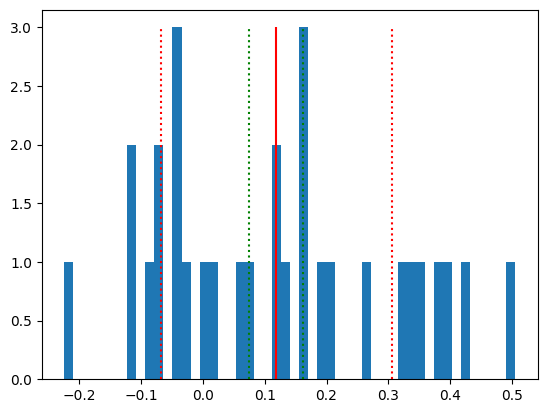

In [9]:
abs_fehler = get_abs_err_confidence_interval(obs=data, alpha=0.1, sided=1)
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results["+sided"] = abs_fehler
show_data(data, e=abs_fehler)

## Intervall mit Sicherheit 90%, einseitiger Hypothese und kleiner Grundgesamtheit
Total wichtig und wird häufig vergessen: Wie oben genannt, wird häufig von eine "unendlichen" Grundgesamtheit ausgegangen. Das ist in der Regel auch fast immer "okay". Wenn die Anzahl der Untersuchungsobjekte weniger als 5% der GG ausmachen, macht es praktisch kaum einen Unterschied. In unserem Fall aber untersuchen wir 30 (n) von 120 (N) Märkten. 
- Einerseits "ohne Zurücklegen": Ein Markt kann ja nicht gleichzeitig in zwei Varianten umgebaut werden.
- Andererseit beobachten immerhin 25% der Fälle. Das gibt mir schon eine höhere Sicherheit als wenn ich 30 von 3000 Märkten (=1%) beobachte.

Daher Bedarf es laut der oben eingebundenen Grafik einer Endlichkeitskorrektur. Oder in cooler: _finite multiplier_.

Endlichkeitskorrektur = $\left(\dfrac{N-n}{N-1}\right)$ 

Also wenn zum Beispiel 30 von 120 Subjekten untersucht werden: $\left(\dfrac{120-30}{120-1}\right) \approx 0.75$

Dadurch schrumpft der absolute Fehler wieder einmal um mehr als einen Prozentpunkt.

Der absolute Fehler beträgt ± 0.033
n=30, mean=0.11901780297332658, std=0.18607539192172678


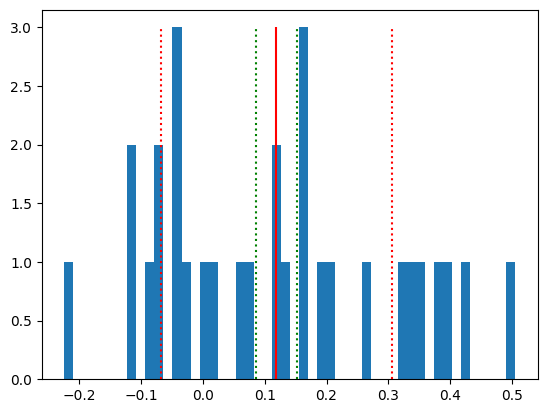

In [10]:
N=120
abs_fehler = get_abs_err_confidence_interval(obs=data, alpha=0.1, sided=1, N=N)
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results["+GG"] = abs_fehler
show_data(data, e=abs_fehler)

## Intervall mit Sicherheit 90%, einseitiger Hypothese, kleiner Grundgesamtheit und bekannter Streuung der Grundgesamtheit

Der absolute Fehler beträgt ± 0.036
n=30, mean=0.11901780297332658, std=0.18607539192172678


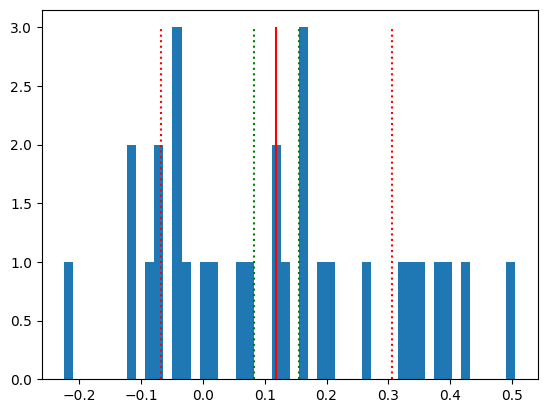

In [11]:
sigma_gg = 0.206
abs_fehler = get_abs_err_confidence_interval(obs=data, alpha=0.1, sided=1, N=N, gg_sigma=sigma_gg)
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results["+GG-sigma"] = abs_fehler
show_data(data, e=abs_fehler)

## Intervall mit Sicherheit 90%, einseitiger Hypothese, kleiner Grundgesamtheit, bekannter Streuung der Grundgesamtheit und Annahme einer T-Verteilung statt Normalverteilung

Der absolute Fehler beträgt ± 0.037
n=30, mean=0.11901780297332658, std=0.18607539192172678


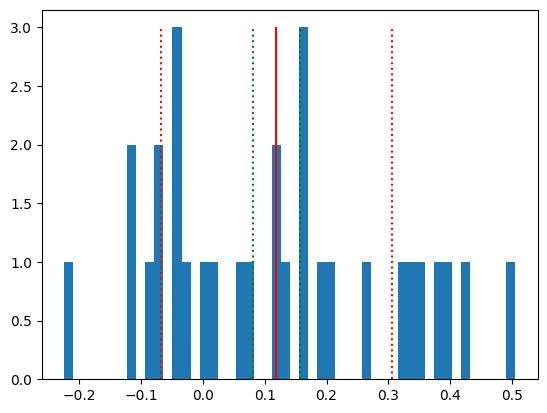

In [12]:
abs_fehler = get_abs_err_confidence_interval(obs=data, alpha=0.1, sided=1, N=N, gg_sigma=sigma_gg, score="t")
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results["+t_dist"] = abs_fehler
show_data(data, e=abs_fehler)

## Überblick über Konfidenzintervalle bei unterschiedlichen Prämissen

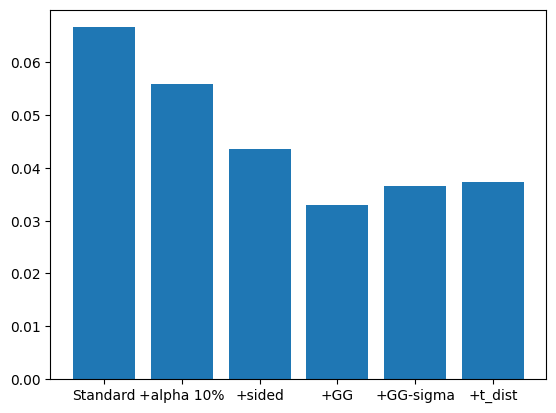

In [13]:
plt.bar(results.keys(), results.values())
plt.show()

## Intervall mit Sicherheit 90%, einseitiger Hypothese, kleiner Grundgesamtheit, bekannter Streuung der Grundgesamtheit, Annahme einer T-Verteilung statt Normalverteilung und transformierter Verteilung

In [71]:
log_data = np.log(data+1)
abs_fehler = get_abs_err_confidence_interval(obs=log_data, alpha=0.1, sided=1, N=N, gg_sigma=sigma_gg, score="t")
print(abs_fehler)
lower = np.exp(log_data.mean() - abs_fehler) - 1 # - data.mean()
upper = np.exp(log_data.mean() + abs_fehler) - 1 # - data.mean()
print(f"Der absoluten Fehler betragen {lower:.2} und {upper:.2}")
print(np.exp(log_data.mean()) - 1)
print(log_data.mean())
print(data.mean())
print(np.log(data.mean()+1))
print(np.exp(np.log(data.mean()+1))-1)
# results["+assymetrisch"] = abs_fehler

0.03730340385614068
Der absoluten Fehler betragen -0.085 und -0.014
-0.05029752823237488
-0.051606531054059435
-0.029045449615452034
-0.02947561880529801
-0.02904544961545208


geschätztes sigma: $\hat \sigma$



n=10000, mean=0.019012681864244693, std=0.20841973315334536


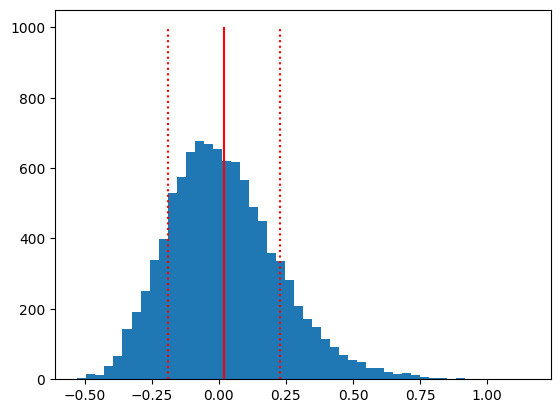

n=10000, mean=-0.001687101906376093, std=0.20269877337759729


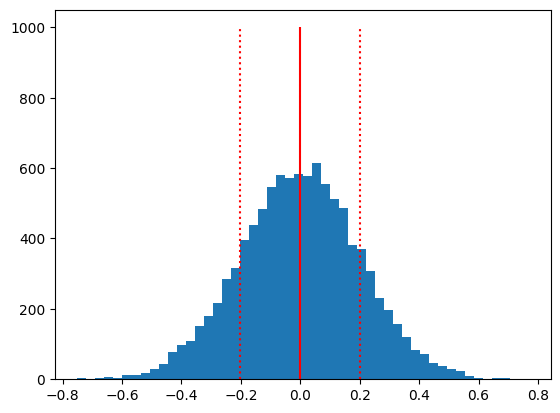

-0.18126924692201818 0.22140275816016985


In [5]:
data_10K = get_sales_change_rates_percent(n=10000)
show_data(data_10K)
plt.show()
log_data_10K = np.log(data_10K + 1)
show_data(log_data_10K)
plt.show()

print(np.exp(-0.2)-1, np.exp(+0.2)-1)

In [ ]:
abs_fehler = get_abs_err_confidence_interval(obs=data, alpha=0.1, sided=1, N=N, gg_sigma=sigma_gg, score="t")
print(f"Der absolute Fehler beträgt ± {abs_fehler:.2}")
results["+t_dist"] = abs_fehler